In [316]:
#Implementing COnvolutional Neural Net from Scratch.
#DataSet Digit Recognizer from Kaggle = https://www.kaggle.com/c/digit-recognizer/data
#Digit 0-9

#get the training data
import pandas as pd
path = r'E:\Study n Work\Machine Learning\Kaggle\Digit Recognizer\Data\train.csv'
train_data = pd.read_csv(path)

In [317]:
#Separating Labels from the dataset.
import numpy as np
train_labels = np.array(train_data['label']).reshape(train_data.shape[0],1)
print(train_labels.shape)

(42000, 1)


In [318]:
#Train dataset.
train_dataset = np.array(train_data.iloc[:,1:785]).reshape(train_data.shape[0],784)
print(train_dataset.shape)

(42000, 784)


In [319]:
#Normalizing the dataset
train_dataset = (train_dataset)/255

In [320]:
#Breaking the dataset into test dataset, valid dataset and train dataset.

test_dataset = np.array(train_dataset[33600:42000]).reshape(8400,784)
test_labels = np.array(train_labels[33600:42000]).reshape(8400,1)

valid_dataset = np.array(train_dataset[25200:33600]).reshape(8400,784)
valid_labels = np.array(train_labels[25200:33600]).reshape(8400,1)

train_dataset = np.array(train_dataset[0:25200])
train_labels = np.array(train_labels[0:25200]).reshape(25200,1)

print(train_dataset.shape,train_labels.shape)
print(valid_dataset.shape,valid_labels.shape)
print(test_dataset.shape,test_labels.shape)

(25200, 784) (25200, 1)
(8400, 784) (8400, 1)
(8400, 784) (8400, 1)


In [321]:
#One Hot Encoding.

neural_train_labels = np.zeros((train_labels.shape[0],10))
neural_valid_labels = np.zeros((valid_labels.shape[0],10))
neural_test_labels = np.zeros((test_labels.shape[0],10))

for i,value in enumerate(train_labels):
    neural_train_labels[i,value] = 1

for i,value in enumerate(valid_labels):
    neural_valid_labels[i,value] = 1

for i,value in enumerate(test_labels):
    neural_test_labels[i,value] = 1

print(neural_train_labels.shape)
print(neural_valid_labels.shape)
print(neural_test_labels.shape)

(25200, 10)
(8400, 10)
(8400, 10)


In [322]:
#Reformatting the dataset

image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  return dataset

train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)

print('Training set', train_dataset.shape, neural_train_labels.shape)
print('Validation set', valid_dataset.shape, neural_valid_labels.shape)
print('Test set', test_dataset.shape, neural_test_labels.shape)

Training set (25200, 28, 28, 1) (25200, 10)
Validation set (8400, 28, 28, 1) (8400, 10)
Test set (8400, 28, 28, 1) (8400, 10)


In [333]:
#pixels
image_size = 28

#greyscale
num_channels = 1

#patch size
patch_size = 3

#depth
depth = 4

#hidden layers
hidden1 = 256

#hyperparameters
learning_rate = 0.1

#regularization
beta = 0

#target_labels
num_classes = 10

In [328]:
#activation function
def sigmoid(X):
    return 1/(1+np.exp(-1*X))
              
#conv multiplication i.e multiplying conv layer with the weights.
def conv_multiply(data,weights):
    logits = np.zeros([data.shape[0]//2,data.shape[1]//2,weights.shape[3]])
    for d in range(weights.shape[3]):
        row = 0
        for rpos in range(0,(data.shape[0]-patch_size+1),2):
            col=0
            for cpos in range(0,(data.shape[1]-patch_size+1),2):
                logits[row,col,d] = np.sum(np.multiply(data[rpos:rpos+patch_size, cpos:cpos+patch_size, :],weights[:,:,:,d]))
                col += 1
            row+=1
    return logits


#conv deltas
def conv_delta(next_delta,weights):
    delta = np.zeros([next_delta.shape[0]*2,next_delta.shape[1]*2,next_delta.shape[2]//4])
    for d2 in range(weights.shape[3]):
        row = 0
        for rpos in range(0,delta.shape[0]-patch_size+1,2):
            col=0
            for cpos in range(0,delta.shape[2]-patch_size+1,2):
                delta[rpos:rpos+patch_size,cpos:cpos+patch_size,:] += (np.multiply(weights[:,:,:,d2],next_delta[row,col,d2]))
                col+=1
            row +=1
    return delta


#conv partial derivatives
def conv_derivatives(delta,activation):
    partial_derivatives = np.zeros([patch_size,patch_size,activation.shape[2],delta.shape[2]])
    for d2 in range(0,partial_derivatives.shape[3]):
        row=0
        for rpos in range(0,activation.shape[0]-patch_size+1,2):
            col = 0
            for cpos in range(0,activation.shape[1]-patch_size+1,2):
                partial_derivatives[:,:,:,d2] += np.multiply(activation[rpos:rpos+patch_size, cpos:cpos+patch_size, :],delta[row,col,d2])
                col += 1
            row += 1
    return partial_derivatives

In [329]:
#Training Algorithm

import numpy as np

#functon to train the program.
def train(train_dataset,train_labels,batch_size=20,iters=101,stride=2):
    #weights
    #conv layer weights
    global conv_layer1_weights
    global conv_layer1_biases
    global conv_layer2_weights
    global conv_layer2_biases
    
    #fully connected layer weights.
    global full_layer1_weights
    global full_layer1_biases
    global full_layer2_weights
    global full_layer2_biases
    
    #initialize weights values with zero mean and 0.5 standard deviation.
    mean = 0
    std = 0.5
    
    #initialize weights
    conv_layer1_weights = np.random.normal(mean,std,(patch_size,patch_size,num_channels,depth))
    conv_layer1_biases = np.zeros([1,depth])
    conv_layer2_weights = np.random.normal(mean,std,(patch_size,patch_size,depth,depth*4))
    conv_layer2_biases = np.zeros([1,depth*4])
    
    full_layer1_weights = np.random.normal(mean,std,((image_size//4 * image_size//4 * depth * 4),hidden1))
    full_layer1_biases = np.zeros([hidden1])
    full_layer2_weights = np.random.normal(mean,std,(hidden1,num_classes))
    full_layer2_biases = np.zeros([num_classes])
    
    #training process.
    for step in range(iters):
        #get the batch data.
        start = (step*batch_size)%(train_dataset.shape[0])
        end = start + batch_size
        batch_dataset = train_dataset[start:end,:,:,:]
        batch_labels = train_labels[start:end,:]
        
        #to store partial derivates
        conv_partial_derivative1 = np.zeros([patch_size,patch_size,num_channels,depth])
        conv_partial_derivative2 = np.zeros([patch_size,patch_size,depth,depth*4])

        full_partial_derivates1 = np.zeros([(image_size//4 * image_size//4 * depth * 4),hidden1])
        full_partial_derivates2 = np.zeros([hidden1,num_classes])
        
        #train on the batch dataset
        for i in range(batch_size):
            #FORWARD PROPAGATION
            #convolution layers activations
            image = batch_dataset[i]
            logits = conv_multiply(image,conv_layer1_weights) + conv_layer1_biases
            activation1 = sigmoid(logits)
            activation2 = sigmoid(conv_multiply(activation1,conv_layer2_weights) + conv_layer2_biases)
            
            
            #fully connected layers activations
            activation2 = np.array(activation2).reshape(1,(image_size // 4 * image_size // 4 * depth * 4))
            activation3 = np.matmul(activation2,full_layer1_weights)+full_layer1_biases
            activation3 = sigmoid(activation3)
            activation4 = np.matmul(activation3,full_layer2_weights)+full_layer2_biases
            activation4 = np.exp(activation4)/np.sum(np.exp(activation4))
            
            
            #BACKWARD PROPAGATION
            #fully connected layers deltas
            delta4 = np.transpose(activation4)-batch_labels[i].reshape(10,1)
            delta3 = np.matmul(full_layer2_weights,delta4)
            delta3 = np.multiply(np.multiply(delta3,np.transpose(activation3)),(1-np.transpose(activation3)))
            delta2 = np.matmul(full_layer1_weights,delta3)
            delta2 = np.multiply(np.multiply(delta2,np.transpose(activation2)),(1-np.transpose(activation2)))
            
            #convolution layer deltas
            conv_delta2 = delta2.reshape(image_size//4,image_size//4,depth*4)
            conv_delta1 = conv_delta(conv_delta2,conv_layer2_weights)
            conv_delta1 = np.multiply(np.multiply(conv_delta1,activation1),(1-activation1))
            
            
            #partial derivatives
            full_partial_derivates2 += np.matmul(np.transpose(activation3),np.transpose(delta4))
            full_partial_derivates1 += np.matmul(np.transpose(activation2),np.transpose(delta3))
            
            conv_partial_derivative2 += conv_derivatives(conv_delta2,activation1)
            conv_partial_derivative1 += conv_derivatives(conv_delta1,image)
            
        #regularization
        full_partial_derivates1 = (full_partial_derivates1 + (beta*full_layer1_weights))/batch_size
        full_partial_derivates2 = (full_partial_derivates2 + (beta*full_layer2_weights))/batch_size
        
        conv_partial_derivative1 = (conv_partial_derivative1 + (beta*conv_layer1_weights))/batch_size
        conv_partial_derivative2 = (conv_partial_derivative2 + (beta*conv_layer2_weights))/batch_size
        
        #update weights
        full_layer1_weights -= (full_partial_derivates1*learning_rate)
        full_layer2_weights -= (full_partial_derivates2*learning_rate)
        conv_layer1_weights -= (conv_partial_derivative1*learning_rate)
        conv_layer2_weights -= (conv_partial_derivative2*learning_rate)
        
        
        #print loss and accuracy of the batch dataset.
        if(step%100==0):
            print('Step : %d'%step)
            loss,accuracy,pred = cal_loss_accuracy_predictions(batch_dataset,batch_labels)
            print('Loss : %f'%loss)
            print('Accuracy : %f%%'%(round(accuracy*100,2)))


            
#function for calculation of loss, accuracy and  predictions.
def cal_loss_accuracy_predictions(batch_dataset,batch_labels):
    global predictions
    predictions = np.zeros([batch_labels.shape[0],batch_labels.shape[1]]);
    
    #predictions.
    for i in range(len(batch_labels)):
        #convolution layers
        image = batch_dataset[i]
        logits = conv_multiply(image,conv_layer1_weights) + conv_layer1_biases
        logits = sigmoid(logits)
        logits = sigmoid(conv_multiply(logits,conv_layer2_weights) + conv_layer2_biases)

        #fully connected layers
        logits = logits.reshape(1,(image_size//4 * image_size//4 * depth * 4))
        logits = sigmoid(np.matmul(logits,full_layer1_weights)+full_layer1_biases)
        logits = np.matmul(logits,full_layer2_weights)+full_layer2_biases
        logits = np.exp(logits)/np.sum(np.exp(logits))
        predictions[i,:] = logits[0]
    
    #accuracy
    accuracy = np.sum(np.argmax(predictions,axis=1)==np.argmax(batch_labels,axis=1))/len(batch_labels)
    
    #loss
    loss=0
    for i in range(len(batch_labels)):
        for j in range(num_classes):
            loss += (-1)*(batch_labels[i,j]*(np.log(predictions[i,j])) + (1-batch_labels[i,j])*(np.log(1-predictions[i,j])))
    loss = loss/len(batch_labels)
    
    return loss,accuracy,predictions

In [334]:
#TRAINING
train(train_dataset,neural_train_labels,iters=1501)

Step : 0
Loss : 10.921501
Accuracy : 20.000000%
Step : 100
Loss : 3.243290
Accuracy : 25.000000%
Step : 200
Loss : 3.009180
Accuracy : 50.000000%
Step : 300
Loss : 1.752908
Accuracy : 65.000000%
Step : 400
Loss : 1.366739
Accuracy : 75.000000%
Step : 500
Loss : 1.192982
Accuracy : 80.000000%
Step : 600
Loss : 1.009519
Accuracy : 85.000000%
Step : 700
Loss : 0.542985
Accuracy : 95.000000%
Step : 800
Loss : 0.803596
Accuracy : 80.000000%
Step : 900
Loss : 0.378653
Accuracy : 95.000000%
Step : 1000
Loss : 0.445274
Accuracy : 95.000000%
Step : 1100
Loss : 0.642086
Accuracy : 90.000000%
Step : 1200
Loss : 0.437865
Accuracy : 100.000000%
Step : 1300
Loss : 0.855016
Accuracy : 85.000000%
Step : 1400
Loss : 0.390386
Accuracy : 95.000000%
Step : 1500
Loss : 0.570026
Accuracy : 95.000000%


In [340]:
_,test_acc,test_pred = cal_loss_accuracy_predictions(test_dataset,neural_test_labels)
_,valid_acc,valid_pred = cal_loss_accuracy_predictions(valid_dataset,neural_valid_labels)
_,train_acc,train_pred = cal_loss_accuracy_predictions(train_dataset,neural_train_labels)

print('Training Accuracy   : {}%'.format(round(train_acc*100,2)))
print('Validation Accuracy : {}%'.format(round(valid_acc*100,2)))
print('Test Accuracy       : {}%'.format(round(test_acc*100,2)))

Training Accuracy   : 85.88%
Validation Accuracy : 85.45%
Test Accuracy       : 85.99%


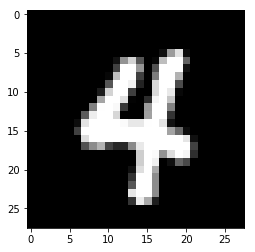

Predicted Label : 4


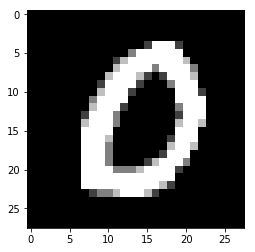

Predicted Label : 0


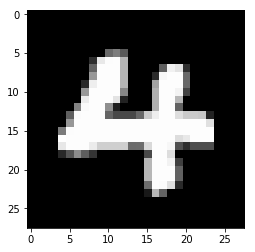

Predicted Label : 4


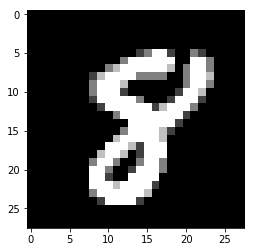

Predicted Label : 8


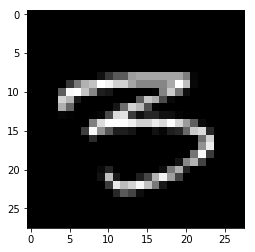

Predicted Label : 3


In [344]:
image = valid_dataset[15:20]
cal_loss_accuracy_predictions(valid_dataset[15:20],neural_valid_labels[15:20])
import matplotlib.pyplot as plt
for i in range(image.shape[0]):
    plt.imshow(image[i,:,:,0],cmap='gray')
    plt.show()
    print('Predicted Label : %d'%np.argmax(predictions[i]))